# Lung Cancer Binary Classifier exploration
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=lungCancerClassificationExploration.ipynb)
- lab attribution


gene expression values are log2(TPM+0.001) 

references:
- [https://ucsc-xena.gitbook.io/project/public-data-we-host/tcga](https://ucsc-xena.gitbook.io/project/public-data-we-host/tcga)
- [https://xenabrowser.net/datapages/?hub=https://toil.xenahubs.net:443](https://xenabrowser.net/datapages/?hub=https://toil.xenahubs.net:443)


In [1]:
import pathlib as pl

import logging
from   setupLogging import setupLogging
#configFilePath = setupLogging( default_path=pl.Path('../src/logging.ini.json'))
configFilePath = setupLogging( default_path=pl.Path('../src/logging.test.ini.json'))
logger = logging.getLogger("notebook")
logger.info("using logging configuration file:{}".format(configFilePath))

from dataUtilities.TCGA_Target_GTex import TCGA_Target_GTex

import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

from matplotlibUtilities.histogram import Histogram as muHistogram
import matplotlibUtilities.utilities as mu
import numpy as np
import pandas as pd

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

[INFO <ipython-input-1-dd065039d2a0>:8 - <module>()] using logging configuration file:../src/logging.test.ini.json


## Load Data

In [2]:
dataDir = pl.Path("../data")
if not dataDir.exists() :
    dataDir.mkdir()
    
loader = TCGA_Target_GTex(dataDir)
XDF, YDF = loader.loadTCGA_Target_GTex()    

[INFO utils.py:129 - _init_num_threads()] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [3]:
XDF.head().iloc[:, 1:5]

sample,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16
GTEX-S4Q7-0003-SM-3NM8M,-9.9658,5.6639,3.9051,3.0145
TCGA-19-1787-01,2.8974,5.2327,1.2333,2.9090
TCGA-S9-A7J2-01,-1.7809,4.6972,2.3366,1.5115
GTEX-QV31-1626-SM-2S1QC,-2.5479,5.2799,2.5238,0.9419
TCGA-G3-A3CH-11,-3.4580,4.3031,1.5064,-0.7588


In [4]:
print("XDF.shape:{}".format(XDF.shape))
first5GenesDf = XDF.iloc[:, 1:5]
print("first 5 genes")
first5GenesDf.describe()

XDF.shape:(19130, 60498)
first 5 genes


sample,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16
count,19130.000000,19130.000000,19130.000000,19130.000000
mean,-4.299505,5.000126,2.163272,1.581072
std,4.235453,1.034459,1.091871,1.422600
min,-9.965800,-9.965800,-9.965800,-9.965800
25%,-9.965800,4.679300,1.709700,0.816400
50%,-3.625900,5.098500,2.325100,1.585400
75%,-1.510500,5.485800,2.791000,2.533800
max,11.086200,8.698100,5.900900,6.364800


## Explore meta data

In [5]:
YDF.head() #.iloc[:, 1:5]

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,Artery - Coronary,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,Heart - Atrial Appendage,Heart,Normal Tissue,Female,GTEX,Normal


In [6]:
print("YDF.shape:{}".format(YDF.shape))
YDF.describe()

YDF.shape:(19130, 7)


,category,disease,primary_site,sample_type,gender,study,tumor_normal
count,19130,19130,19130,19130,19130,19130,19130
unique,93,93,47,16,3,3,2
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor
freq,1212,1212,1846,9185,10456,10534,10530


### Explore the distrubtion of 'categories'
what is the difference between category, disease, primary_site	meta data? Values seem like they are the same? Is there a bug in the data clean up pipeline?

Text(0.5, 1.0, 'Fig. 1 Category counts')

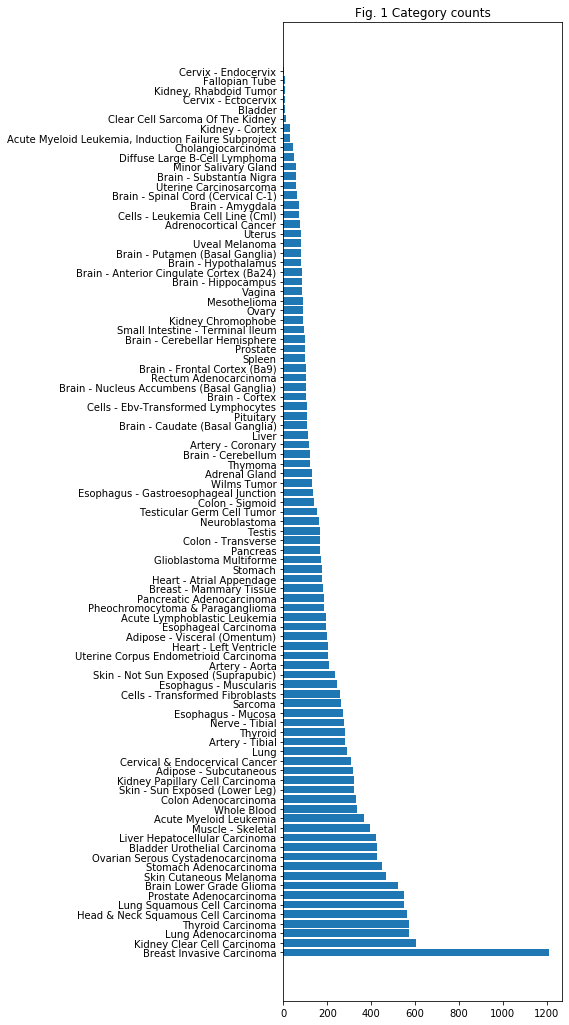

In [7]:
def plotCategoryCounts(df, colNameStr):
    '''
    TODO: make this more generic
    argument 
        df: a pandas data frame 
        colNameStr: 
        
    returns:
        (fix, axis)
    '''
    # countDF is series
    countDF = df[colNameStr].value_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 18)
    ax.barh(countDF.index, countDF)

    return (fig, ax)


fig, ax = plotCategoryCounts(YDF, "category")
ax.set_title("Fig. 1 Category counts")

In [8]:
uniqueCategoriesArray =  pd.unique(  YDF.loc[:, 'category' ] )
print(type(uniqueCategoriesArray))
uniqueCategoriesArray

<class 'numpy.ndarray'>


array(['Adipose - Subcutaneous', 'Muscle - Skeletal', 'Artery - Tibial',
       'Artery - Coronary', 'Heart - Atrial Appendage',
       'Adipose - Visceral (Omentum)', 'Ovary', 'Uterus',
       'Breast - Mammary Tissue', 'Minor Salivary Gland',
       'Brain - Cortex', 'Adrenal Gland', 'Thyroid', 'Lung', 'Pancreas',
       'Esophagus - Muscularis', 'Esophagus - Mucosa', 'Stomach',
       'Skin - Not Sun Exposed (Suprapubic)', 'Colon - Sigmoid',
       'Small Intestine - Terminal Ileum', 'Colon - Transverse',
       'Prostate', 'Testis', 'Skin - Sun Exposed (Lower Leg)',
       'Nerve - Tibial', 'Heart - Left Ventricle', 'Spleen', 'Pituitary',
       'Brain - Cerebellum', 'Cells - Transformed Fibroblasts',
       'Whole Blood', 'Esophagus - Gastroesophageal Junction',
       'Cells - Ebv-Transformed Lymphocytes', 'Artery - Aorta', 'Vagina',
       'Liver', 'Brain - Substantia Nigra',
       'Brain - Anterior Cingulate Cortex (Ba24)',
       'Brain - Frontal Cortex (Ba9)', 'Brain - Cereb

In [9]:
uniquediseasesArray =  pd.unique(  YDF.loc[:, 'disease' ] )
print(type(uniquediseasesArray))
uniquediseasesArray

<class 'numpy.ndarray'>


array(['Adipose - Subcutaneous', 'Muscle - Skeletal', 'Artery - Tibial',
       'Artery - Coronary', 'Heart - Atrial Appendage',
       'Adipose - Visceral (Omentum)', 'Ovary', 'Uterus',
       'Breast - Mammary Tissue', 'Minor Salivary Gland',
       'Brain - Cortex', 'Adrenal Gland', 'Thyroid', 'Lung', 'Pancreas',
       'Esophagus - Muscularis', 'Esophagus - Mucosa', 'Stomach',
       'Skin - Not Sun Exposed (Suprapubic)', 'Colon - Sigmoid',
       'Small Intestine - Terminal Ileum', 'Colon - Transverse',
       'Prostate', 'Testis', 'Skin - Sun Exposed (Lower Leg)',
       'Nerve - Tibial', 'Heart - Left Ventricle', 'Spleen', 'Pituitary',
       'Brain - Cerebellum', 'Cells - Transformed Fibroblasts',
       'Whole Blood', 'Esophagus - Gastroesophageal Junction',
       'Cells - Ebv-Transformed Lymphocytes', 'Artery - Aorta', 'Vagina',
       'Liver', 'Brain - Substantia Nigra',
       'Brain - Anterior Cingulate Cortex (Ba24)',
       'Brain - Frontal Cortex (Ba9)', 'Brain - Cereb

In [10]:
uniquePrimarySiteArray =  pd.unique(  YDF.loc[:, 'primary_site' ] )
print(type(uniquePrimarySiteArray))
uniquePrimarySiteArray

<class 'numpy.ndarray'>


array(['Adipose Tissue', 'Muscle', 'Blood Vessel', 'Heart', 'Ovary',
       'Uterus', 'Breast', 'Salivary Gland', 'Brain', 'Adrenal Gland',
       'Thyroid', 'Lung', 'Pancreas', 'Esophagus', 'Stomach', 'Skin',
       'Colon', 'Small Intestine', 'Prostate', 'Testis', 'Nerve',
       'Spleen', 'Pituitary', 'Blood', 'Vagina', 'Liver', 'Kidney',
       'Bladder', 'Fallopian Tube', 'Cervix Uteri', 'nan', 'Bone Marrow',
       'White blood cell', 'SympatheticÊNervous System', 'Endometrium',
       'Cervix', 'Soft tissue,Bone', 'Thymus', 'Lining of body cavities',
       'Bile duct', 'Thyroid Gland', 'Head and Neck region', 'Rectum',
       'Lymphatic tissue', 'Adrenal gland', 'Paraganglia', 'Eye'],
      dtype=object)

### How many lung cancer samples are there?

In [11]:
LungCancerRows = YDF['primary_site'].str.contains('un', case=False)
lungMetaDF = YDF.loc[LungCancerRows, :] 
lungMetaDF

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-111CU-0326-SM-5GZXO,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111FC-1126-SM-5GZWU,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111VG-0726-SM-5GIDC,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-111YS-0626-SM-5GZXV,Lung,Lung,Lung,Normal Tissue,Male,GTEX,Normal
GTEX-1122O-0126-SM-5GICA,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal
...,...,...,...,...,...,...,...
TCGA-O2-A52V-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Female,TCGA,Tumor
TCGA-O2-A52W-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Male,TCGA,Tumor
TCGA-O2-A5IB-01,Lung Squamous Cell Carcinoma,Lung Squamous Cell Carcinoma,Lung,Primary Tumor,Female,TCGA,Tumor


### How any examples are there for each kind of lung cancer

In [12]:
lungMetaDF.groupby('category').count()

,disease,primary_site,sample_type,gender,study,tumor_normal
category,,,,,,
Lung,288,288,288,288,288,288
Lung Adenocarcinoma,574,574,574,574,574,574
Lung Squamous Cell Carcinoma,548,548,548,548,548,548


## lung cancer , not lung cancer RNA Seq distribution

In [13]:
lungCancerDF = XDF.loc[LungCancerRows.to_numpy(), :] 
print(lungCancerDF.shape)
rows = 1 # if the data is data frame rows=0 and cols = 1
cols = 0
averageLungCancerRNASeq = lungCancerDF.mean(axis=cols)
print(type(averageLungCancerRNASeq))
print(averageLungCancerRNASeq.head())
print("\n averageLungCancerRNASeq.shape:{}".format(averageLungCancerRNASeq.shape))
# print("\n average Lung Cancer RNAS Seq.describe".\
#       format( averageLungCancerRNASeq.describe() ))
print(averageLungCancerRNASeq.describe())
print()
      
# ~ is 'not' in pandas
notLungCancerDF = XDF.loc[ np.logical_not( LungCancerRows.to_numpy() ), :]
averageNotLungCancerRNASeq = notLungCancerDF.mean(axis=cols)

print(averageNotLungCancerRNASeq.head())
print("\n averageNotLungCancerRNASeq.shape:{}".format(averageNotLungCancerRNASeq.shape))
# print("\n average Not Lung Cancer RNA Seq.describe\n{}".format(averageNotLungCancerRNASeq.describe() ))
print(averageNotLungCancerRNASeq.describe())

(1410, 60498)
<class 'pandas.core.series.Series'>
sample
ENSG00000000003.14    3.619024
ENSG00000000005.5    -4.292961
ENSG00000000419.12    4.977786
ENSG00000000457.13    2.148156
ENSG00000000460.16    1.558658
dtype: float32

 averageLungCancerRNASeq.shape:(60498,)
count    60498.000000
mean        -5.128656
std          5.405312
min         -9.965819
25%         -9.813991
50%         -7.874546
75%         -0.508669
max         14.010634
dtype: float64

sample
ENSG00000000003.14    3.742239
ENSG00000000005.5    -4.299937
ENSG00000000419.12    5.001886
ENSG00000000457.13    2.164459
ENSG00000000460.16    1.582848
dtype: float32

 averageNotLungCancerRNASeq.shape:(60498,)
count    60498.000000
mean        -5.102002
std          5.410504
min         -9.967390
25%         -9.800651
50%         -7.837829
75%         -0.464622
max         14.023088
dtype: float64


xMin:-10.967390060424805 xMax:15.023087501525879
ylimMin:1.0 ylimMax:14.298486873992337


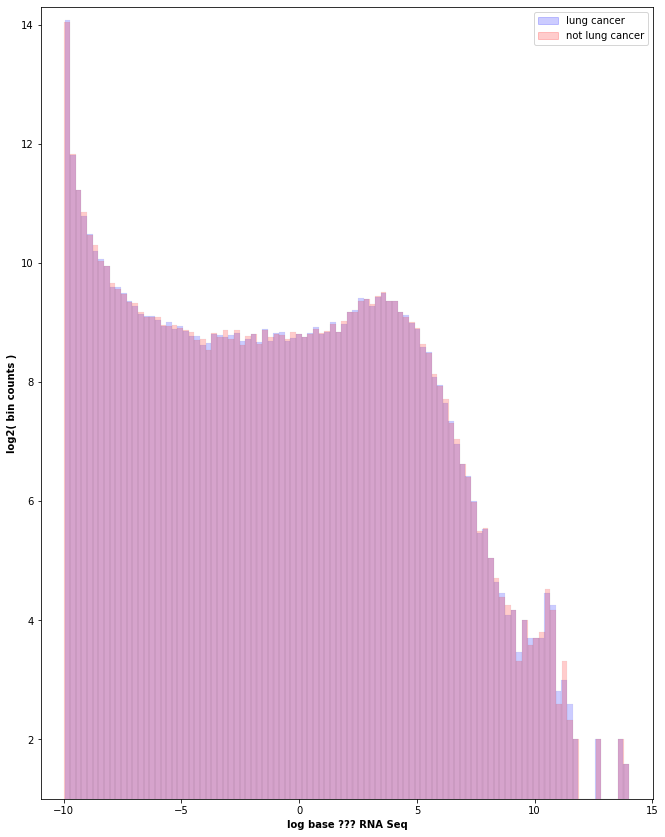

In [15]:
# FIXME: AEDWIP: ledge colors are easy to break, you need to know color and alpha

# standard paper size is 8.5 inches x 11 inches
pageWidthInInches  = 8.5
pageHeightInInches = 11  
fig = plt.figure( figsize=(pageWidthInInches, pageHeightInInches) )
panel = mu.createPanel(fig, pageWidthInInches, pageHeightInInches, 
                       leftRelativeSize=0, 
                       bottomRelativeSize=0)
numBins = 100
#VollmerBlue = (53, 106, 201)
cancerColor = (0, 0, 255)
alpha = 0.2
meanLungRNASeqNP = averageLungCancerRNASeq.to_numpy()
# meanLungRNASeqNPLog10 = np.log10(meanLungRNASeqNP)
lungCancerHist = muHistogram(panel, meanLungRNASeqNP, numBins, 
                             RGBTuple=cancerColor, alpha=alpha, scale=True,
                            label='lung cancer')


meanNotLungRNASeqNP = averageNotLungCancerRNASeq.to_numpy()
# meanNotLungRNASeqNPLog10 = np.log10(meanNotLungRNASeqNP)
notCancerColor = (255, 0, 0)
notLungCancerHist = muHistogram(panel, meanNotLungRNASeqNP, numBins, 
                             RGBTuple=notCancerColor, alpha=alpha, scale=True,
                               label='not lung cancer')

xlimMin = np.min(meanNotLungRNASeqNP) - 1
xlimMax = np.max(meanNotLungRNASeqNP) + 1
print("xMin:{} xMax:{}".format(xlimMin, xlimMax))
panel.set_xlim(xlimMin,xlimMax)


ylimMin = np.min(notLungCancerHist.binCounts)# - 2
ylimMax = np.max(notLungCancerHist.binCounts) + 0.25 #+ 100
print("ylimMin:{} ylimMax:{}".format(ylimMin, ylimMax)) # max count base_10 15,304
panel.set_ylim(ylimMin, ylimMax)

panel.set_xlabel("log base ??? RNA Seq", fontsize=10, fontweight='bold')
panel.set_ylabel("log2( bin counts )", fontsize=10, fontweight='bold')

colorMapTuples = [cancerColor,   notCancerColor]
labels         = ["lung cancer","not lung cancer"]
mu.addLegend(panel, colorMapTuples, labels, alpha=alpha)

In [ ]:
haldksls fskd xsllungDF.shape

In [ ]:
# standard paper size is 8.5 inches x 11 inches
pageWidthInInches  = 10
pageHeightInInches = 5  
fig = plt.figure( figsize=(pageWidthInInches, pageHeightInInches) )
panel = plt.gca()
meanRNASeqNP = averageLungCancerRNASeq.to_numpy()
panel.bar(meanRNASeqNP, 0.1, label='mean lung')



In [ ]:
df = pd.DataFrame({"A":[1, 2, 3, 4, 5], 
                   "B":[1, 2, 3, 4, 5],
                   }) 

rows = 0
cols = 1
df.mean(axis=cols) # no arg == axis = 0 3.0 = 15 / 3

In [ ]:
print(LungCancerRows.head())
print(type(LungCancerRows))
print()

print("~ is not in pandas")
print(~LungCancerRows.head())
